refer source: [Visualizing and Animating Optimization Algorithms with Matplotlib](http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/) 

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

We shall restrict our attention to 3-dimensional problems for right now (i.e. optimizing over only 2 parameters), though what follows can be extended to higher dimensions by plotting all pairs of parameters against each other, effectively projecting the problem to 3-dimensions. 

The Wikipedia article on [Test functions for optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization) has a few functions that are useful for evaluating optimization algorithms. In particular, we shall look at **Beale's function**:

$$
f(x, y) = (x+2y-7)^2 + (2x+y-5)^2
$$

In [3]:
f  = lambda x, y: (x+2*y-7)**2 + (2*x+y-5)**2

In [4]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x, y)

## 3D plot

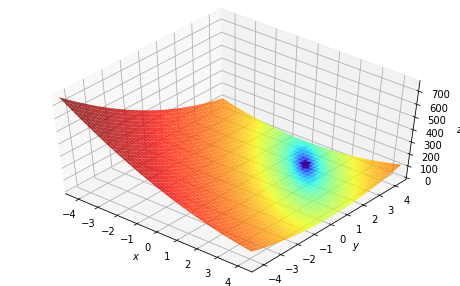

In [18]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))


#plt.title('$f(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$')

plt.show()

In [5]:
minima = np.array([1., 3.])
f(*minima)

0.0

In [6]:
minima_ = minima.reshape(-1, 1)
minima_
f(*minima_)

array([0.])

In [7]:
func = value_and_grad(lambda args: f(*args))

## momentum

In [8]:
def backtracking_line(f,x,grad_f,t=0.01,verbose=False):
    a=1/2
    b=1/2
    
    if verbose:
        print('g '+str(grad_f))
        print(f(x-t*grad_f)[0])
        print(a*t*np.dot(np.transpose(grad_f),grad_f))
    while f(x-t*grad_f)[0]>f(x)[0]-a*t*np.dot(np.transpose(grad_f),grad_f):
        t=b*t
    #x=x-t*grad_f
    if verbose:
        print('t '+str(t))
        print('x '+str(x))
    return t

In [9]:
def momentum(f,iterx,maxstep=400,t=0.1,verbose=False,gamma=0.9,rate=5,threshold=1e-2,debug=False,forget=False):
    path_=[]
    fvs=[]
    step=0
    v=0
    zv,grad=func(iterx)
    while(step<maxstep and (len(grad[abs(grad)>1e-6])>0)):
        path_.append(iterx)
        lastGrad=grad
        zv,grad=func(iterx)

        # print(np.dot(np.transpose(grad),lastGrad))

        
        learning_rate=backtracking_line(f=func,x=iterx,grad_f=grad,t=t,verbose=verbose)

        v=gamma*v+learning_rate*grad
        fvs.append(zv)
        
        if debug and len(grad[abs(grad)<threshold])>1:
            learning_rate*=learning_rate*rate
        # if step%100==0:
        #     pass
        #     print(learning_rate)
        iterx=iterx-v
        step+=1
    # print(iterx)
    # print(func(iterx))
    # print(step)
    path=np.array(path_).T
    path=path[0]
    return path,fvs,step

In [10]:
def momentum_forget(f,iterx,maxstep=400,t=0.1,verbose=False,gamma=0.9,rate=5,threshold=1e-2,debug=False,forget=False):
    path_=[]
    fvs=[]
    step=0
    v=0
    zv,grad=func(iterx)
    newG=gamma
    while(step<maxstep and (len(grad[abs(grad)>1e-6])>0)):
        path_.append(iterx)
        lastGrad=grad
        zv,grad=func(iterx)

        # print(np.dot(np.transpose(grad),lastGrad))

        
        learning_rate=backtracking_line(f=func,x=iterx,grad_f=grad,t=t,verbose=verbose)
        if forget and np.dot(np.transpose(grad),lastGrad)<0:
            # print(step)
            # print(grad)
            # print(lastGrad)
            newG=newG*0.9
            # print(newG)
            
            v=newG*v+learning_rate*grad
        else:
            v=gamma*v+learning_rate*grad
        fvs.append(zv)
        
        if debug and len(grad[abs(grad)<threshold])>1:
            learning_rate*=learning_rate*rate
        # if step%100==0:
        #     pass
        #     print(learning_rate)
        iterx=iterx-v
        step+=1
    # print(iterx)
    # print(func(iterx))
    # print(step)
    path=np.array(path_).T
    path=path[0]
    return path,fvs,step

In [22]:
    def backtrack(f,iterx,grad,maxstep=400,t=0.1,verbose=False):
        path_=[]
        step=0
        while(step<maxstep and (len(grad[abs(grad)>1e-6])>0)):
            path_.append(iterx)

            zv,grad=func(iterx)
            learning_rate=backtracking_line(f=func,x=iterx,grad_f=grad,t=t,verbose=verbose)
            # if step%100==0:
            #     pass
            #     print(learning_rate)
            iterx=iterx-learning_rate*grad
            step+=1
        # print(grad)
        # print('step: '+str(step))
        path=np.array(path_).T
        path=path[0]
        return path,step

## evaluation

In [31]:
year = datetime.timedelta(0)
year

datetime.timedelta(0)

In [37]:
import datetime
path1=[]
path2=[]
path3=[]
interval1=datetime.timedelta(0)
interval2=datetime.timedelta(0)
interval3=datetime.timedelta(0)

step1=0
step2=0
step3=0

diverge1=0
diverge2=0
diverge3=0

maxStep=120

for i in range(30):
    init= 2*xmax*(np.random.random(size=[2,1])-0.5*np.ones([2,1]))#np.array([[3.],[4.]])#



    # momentum forget
    start = datetime.datetime.now()
    for repeat in range(1):
        path1,fvs,step=momentum_forget(f=func,iterx=init,maxstep=maxStep,gamma=0.2,t=1,verbose=False,debug=False,forget=True)
        # print(step)
    end = datetime.datetime.now()

    interval = end - start
    # print(interval)
    interval1+=interval
    step1+=step
    if step>maxStep:
        # print('mf diverge')
        diverge1+=1

    # momentum
    start = datetime.datetime.now()
    for repeat in range(1):
        path2,fvs,step=momentum(f=func,iterx=init,maxstep=maxStep,gamma=0.5,t=1,verbose=False,debug=False,forget=False)
        # print(step)
    end = datetime.datetime.now()

    interval = end - start
    # print(interval)

    interval2+=interval
    step2+=step
    if step>maxStep:
        # print('mo diverge')
        diverge2+=1
    # backtracking line
    fv,grad=func(init)
    start = datetime.datetime.now()
    for repeat in range(1):
        
        path3,step=backtrack(f=func,iterx=init,grad=grad,maxstep=maxStep,t=1,verbose=False)
        # print(step)
    end = datetime.datetime.now()

    interval = end - start
    # print(interval)
    interval3+=interval
    step3+=step
    if step>maxStep:
        diverge3+=1
        print('bk diverge')
    print('*****************************')


    


*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************
*****************************


In [39]:
print(interval1/30)
print(interval2/30)
print(interval3/30)

print(step1/30)
print(step2/30)
print(step3/30)

print(diverge1)
print(diverge2)
print(diverge3)
print()

0:00:00.253948
0:00:00.342282
0:00:00.206085
44.1
52.5
41.0
0
0
0



In [ ]:
interval1=datetime.timedelta(0)
interval2=datetime.timedelta(0)
interval3=datetime.timedelta(0)

step1=0
step2=0
step3=0

diverge1=0
diverge2=0
diverge3=0

In [ ]:
init=np.array([[-3.9],[1.2]])#np.array([[2.9],[.2]])#
limit=0.2
# xmin, xmax, xstep = init[0][0]-limit, init[0][0]+limit, .002
# ymin, ymax, ystep = init[1][0]-limit, init[1][0]+limit, .002
# x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
# z = f(x, y)
path2,fvs=momentum(f=func,iterx=init,maxstep=150,gamma=0.5,t=1,verbose=False,debug=False,forget=True)
path=path2
# plot2
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.plot()

[[1.        ]
 [3.00000003]]
(array([5.50196162e-15]), array([[2.76837850e-07],
       [3.31124342e-07]]))
54


[]

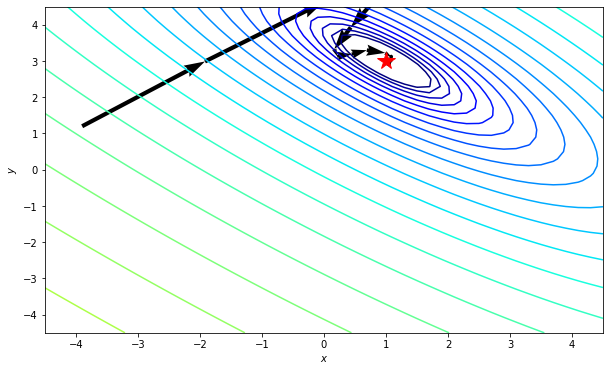

In [18]:
path2,fvs=momentum(f=func,iterx=init,maxstep=150,gamma=0.5,t=1,verbose=False,debug=False,forget=False)
path=path2
# plot2
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.plot()

In [9]:
def backtracking_line(f,x,grad_f,t=0.01,verbose=False):
    a=1/2
    b=1/2
    
    if verbose:
        print('g '+str(grad_f))
        print(f(x-t*grad_f)[0])
        print(a*t*np.dot(np.transpose(grad_f),grad_f))
    while f(x-t*grad_f)[0]>f(x)[0]-a*t*np.dot(np.transpose(grad_f),grad_f):
        t=b*t
    #x=x-t*grad_f
    if verbose:
        print('t '+str(t))
        print('x '+str(x))
    return t

[[-2.20021386]
 [-3.53091939]]


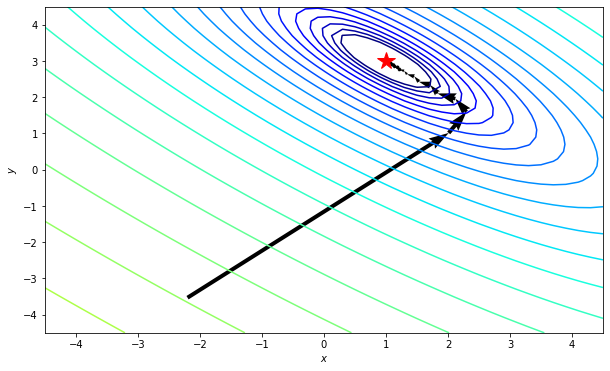

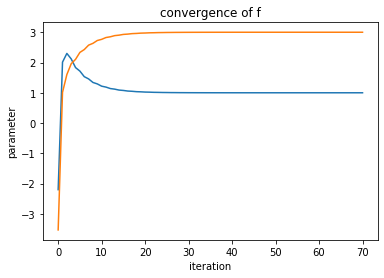

ValueError: x and y can be no greater than 2-D, but have shapes (71,) and (71, 2, 1)

In [10]:
for i in range(1):
    step=0
    learning_rate=0.00001
    grad=np.ones([2,1])
    path_=[]
    grads=[]
    init= 2*xmax*(np.random.random(size=[2,1])-0.5*np.ones([2,1]))#np.array([[3.],[4.]])#

    print(init)

    while(step<600 and (len(grad[abs(grad)>1e-6])>0)) :
        path_.append(init)
        
        zv,grad=func(init)
        grads.append(grad)
        learning_rate=backtracking_line(f=func,x=init,grad_f=grad,t=0.1,verbose=False)
        # if step%100==0:
        #     pass
        #     print(learning_rate)
        init=init-learning_rate*grad
        step+=1

    path=np.array(path_).T
    path=path[0]

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
    ax.plot(*minima_, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    plt.show()
    plt.plot(path[0])
    plt.plot(path[1])
    plt.title('convergence of f')
    plt.ylabel('parameter')
    plt.xlabel('iteration')

    plt.show()
    plt.plot(grads)
    plt.plot(grads[1])
    plt.title('convergence of f')
    plt.ylabel('parameter')
    plt.xlabel('iteration')

    plt.show()

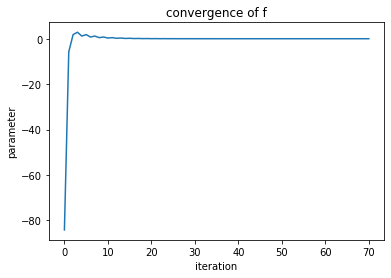

In [11]:
    plt.plot(np.transpose(grads)[0][0][-100:])
    # plt.plot(grads[1])
    plt.title('convergence of f')
    plt.ylabel('parameter')
    plt.xlabel('iteration')

    plt.show()

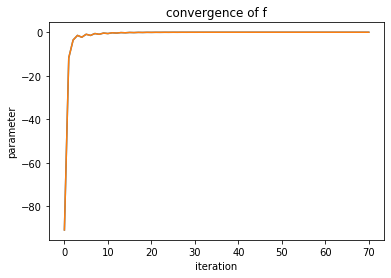

In [12]:
    plt.plot(np.transpose(grads)[0][1][-100:])
    plt.plot(np.transpose(grads)[0][1][-100:])
    # plt.plot(grads[1])
    plt.title('convergence of f')
    plt.ylabel('parameter')
    plt.xlabel('iteration')

    plt.show()

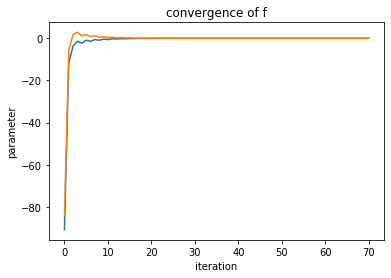

In [13]:
    plt.plot(np.transpose(grads)[0][1][-100:])
    plt.plot(np.transpose(grads)[0][0][-100:])
    # plt.plot(grads[1])
    plt.title('convergence of f')
    plt.ylabel('parameter')
    plt.xlabel('iteration')

    plt.show()

In [14]:
grad

array([[ 4.68472450e-07],
       [-9.18827494e-07]])

[[ 3.72508985e-07]
 [-9.25805956e-07]]
[[ 9.11379511e-07]
 [-2.14252221e-07]]
[[ 9.66774648e-07]
 [-7.49828097e-07]]
[[-5.66388753e-07]
 [ 8.13517337e-07]]
[[-8.78507054e-07]
 [ 5.84779361e-07]]
[[ 2.01470368e-07]
 [-8.56852292e-07]]


[]

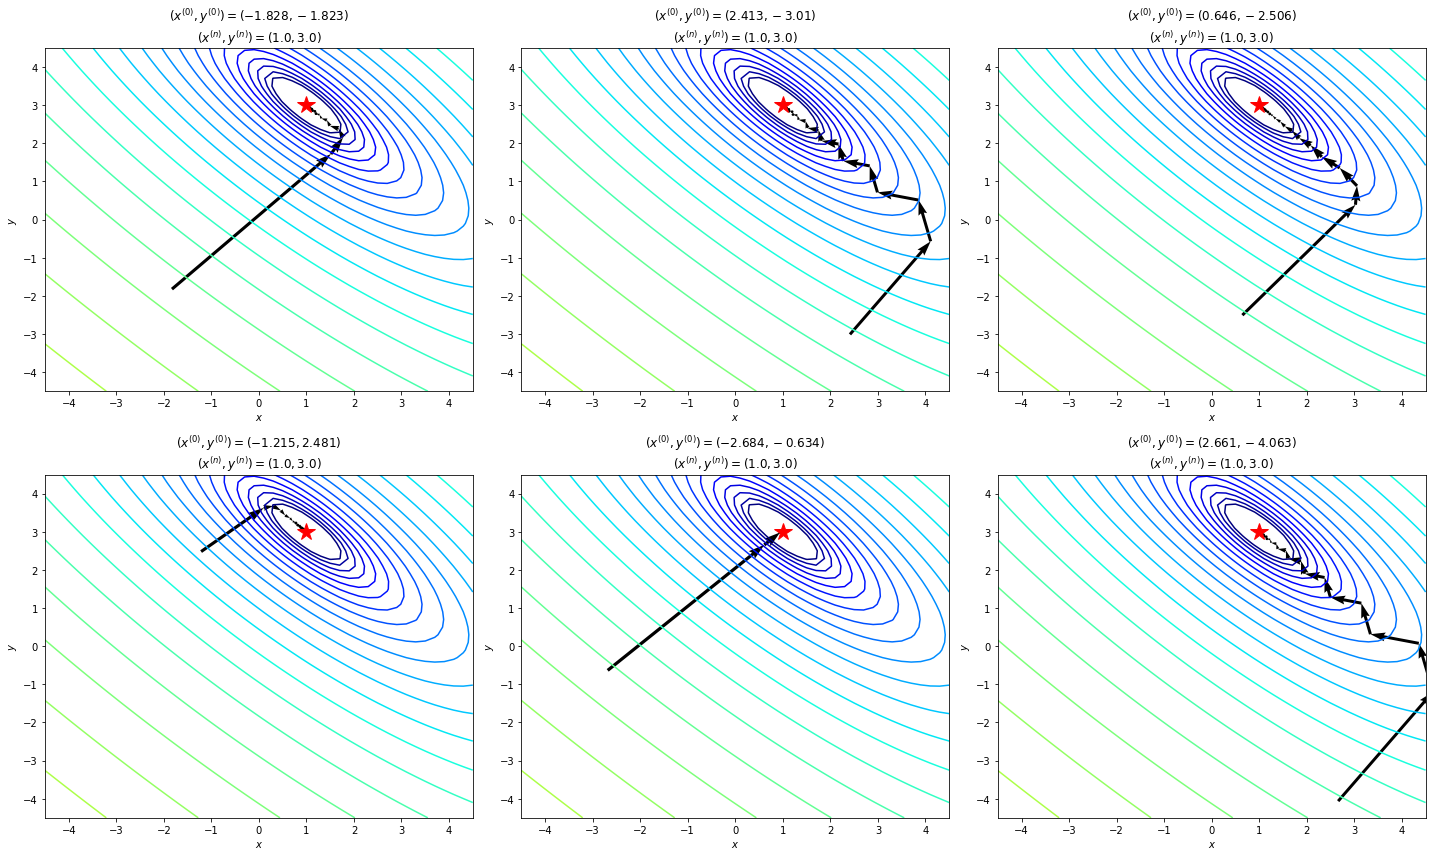

In [17]:
fig=plt.figure(figsize=(20,12))
for i in range(6):
    step=0
    # learning_rate=0.00001
    grad=np.ones([2,1])
    path_=[]
    init= 2*xmax*(np.random.random(size=[2,1])-0.5*np.ones([2,1]))#np.array([[3.],[4.]])#
    iterx=init
    while(step<400 and (len(grad[abs(grad)>1e-6])>0)) :
        path_.append(iterx)

        zv,grad=func(iterx)
        learning_rate=backtracking_line(f=func,x=iterx,grad_f=grad,t=0.1,verbose=False)
        # if step%100==0:
        #     pass
        #     print(learning_rate)
        iterx=iterx-learning_rate*grad
        step+=1
    print(grad)
    path=np.array(path_).T
    path=path[0]

    # plot
    ax = plt.subplot(2,3,i+1)#s(figsize=(10, 6))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
    ax.plot(*minima_, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.title('$(x^{(0)},y^{(0)})=('+str(np.round(init[0][0],3))+','+str(np.round(init[1][0],3))+')$\n$(x^{(n)},y^{(n)})=('+str(np.round(iterx[0][0],3))
+','+str(np.round(iterx[1][0],3))+')$')
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
plt.tight_layout()
plt.plot()

In [23]:
init[0][0]

2.9565202468115293

In [28]:
init[1][0]

0.489136840288977

In [29]:
np.round(init[0][0],3)
np.round(init[1][0],3)

0.489

[]

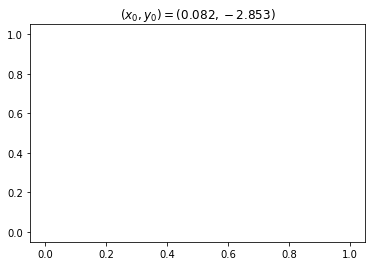

In [38]:
plt.title('$(x^{(0)},y^{(0)})=('+str(np.round(init[0][0],3))
+','+str(np.round(init[1][0],3))+')$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.plot()

In [16]:
    def backtrack(f,iterx,grad,maxstep=400,t=0.1,verbose=False):
        path_=[]
        step=0
        while(step<maxstep and (len(grad[abs(grad)>1e-6])>0)):
            path_.append(iterx)

            zv,grad=func(iterx)
            learning_rate=backtracking_line(f=func,x=iterx,grad_f=grad,t=t,verbose=verbose)
            # if step%100==0:
            #     pass
            #     print(learning_rate)
            iterx=iterx-learning_rate*grad
            step+=1
        print(grad)
        print('step: '+str(step))
        path=np.array(path_).T
        path=path[0]
        return path

[[-3.96015695e-07]
 [ 8.41533350e-07]]
step: 41


[]

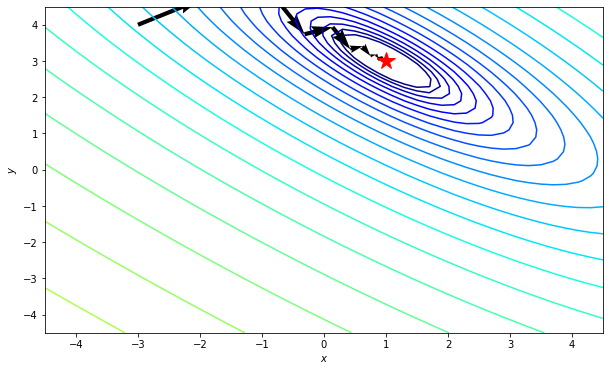

In [17]:
step=0
learning_rate=0.001
grad=np.ones([2,1])

init= np.array([[-3.],[4.]])#2*xmax*(np.random.random(size=[2,1])-0.5*np.ones([2,1]))#

path=backtrack(f=func,iterx=init,grad=grad,maxstep=400,t=1,verbose=False)

# plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.plot()

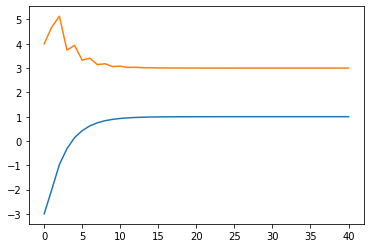

In [18]:
plt.plot(path[0])
plt.plot(path[1])

In [19]:
def skateStep(f,x,t=1,threshold=1e-2,maxStep=50,rate=2,verbose=False):
    '''
    Args:
    @f_x, function return value and gradient
    @df_dx, first order derivative of f_x
    @x, initial x
    @t, initial learing rate
    @threshold, transform to skate mode limit
    @maxStep, max iteration times
    '''
    skateMode=False
    finalMode=False
    step=0
    fv,grad=f(x)

    path_=[]
        
    
    while(step<maxStep and len(grad[abs(grad)>1e-6])>0) :
        fv,grad=f(x)
        path_.append(x)
        if skateMode==False:
            learning_rate=backtracking_line(f=f,x=x,grad_f=grad,t=t)
            x=x-learning_rate*grad
        if finalMode==False and skateMode==False and len(grad[abs(grad)<threshold])>1:
            # print(grad,x)
            skate=learning_rate*rate
            skateMode=True
            minVal=fv
            minSite=x
            minVal2=fv
            minSite2=x
        if skateMode==True:
            if verbose:
                print(grad)
                print(skate)
            # record min value and min site(and 2)
            if len(grad[abs(grad)<threshold])>1:
                x=x-skate*grad
                fv,grad=f(x)
                if verbose:
                    print('skate')
                    print(step)
                if fv<minVal:
                    if verbose:
                        print('less')
                    minVal=fv
                    minSite=x
                else:
                    if verbose:
                        print('here')
                    # return to last step
                    x=minSite
                    y=fv
                    x=(y/(minVal+y))*(minSite-x)+x
                    finalMode=True
                    skateMode=False
            else:
                if verbose:
                    print('saddle')
                skateMode=False

        if finalMode==True:
            learning_rate=backtracking_line(f=f,x=x,grad_f=grad,t=t)
            x=x-learning_rate*grad
        step+=1
    print(grad)
    print(step)
    path=np.array(path_).T
    path=path[0]

    print('*******************')
    print(fv)
    return path
    #return x,step

In [20]:
fooa=np.asarray([[2],[2]])
foob=np.asarray([[1],[2]])
fooa/(fooa+foob)

array([[0.66666667],
       [0.5       ]])

[[-4.40166549e-07]
 [-4.40166549e-07]]
35
*******************
[1.07636995e-14]


[]

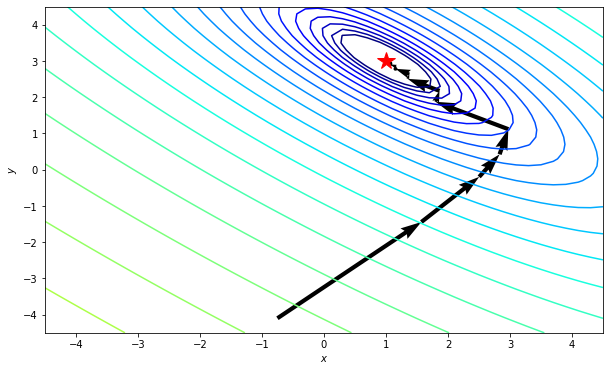

In [21]:
step=0
learning_rate=0.001
grad=np.ones([2,1])
path_=[]
init= 2*xmax*(np.random.random(size=[2,1])-0.5*np.ones([2,1]))#np.array([[3.],[4.]])#
for i in range(1,2):
    path=skateStep(f=func,x=init,t=1,threshold=1e-2,maxStep=100,rate=i)#backtrack(f=func,iterx=init,grad=grad,maxstep=400,t=1,verbose=False)
    

# plot1
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.plot()





[[ 7.07521965e-07]
 [-4.55998219e-07]]
step: 43


[]

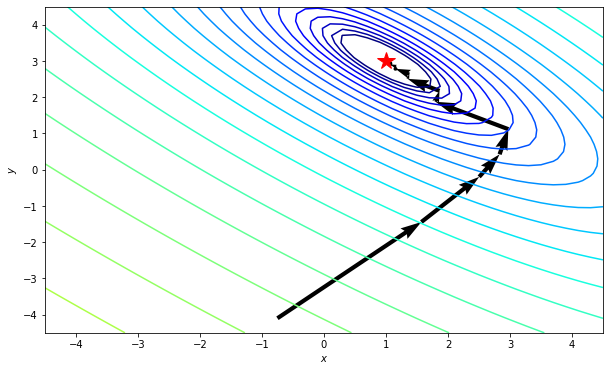

In [22]:
path2=backtrack(f=func,iterx=init,grad=grad,maxstep=100,t=1,verbose=False)
path=path2
# plot2
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.plot()

In [28]:
learning_rate=0.001
grad=np.ones([2,1])
for i in range(1,2):
    init= 2*xmax*(np.random.random(size=[2,1])-0.5*np.ones([2,1]))#np.array([[3.],[4.]])#
    path=skateStep(f=func,x=init,t=1,threshold=1e-2,maxStep=100,rate=1.2,verbose=True)#backtrack(f=func,iterx=init,grad=grad,maxstep=400,t=1,verbose=False)
    path2=backtrack(f=func,iterx=init,grad=grad,maxstep=100,t=1,verbose=False)

[[-0.00603342]
 [ 0.00959365]]
0.3
skate
18
less
[[-0.0150617 ]
 [-0.01662441]]
0.3
saddle
[[-0.00619882]
 [-0.00766386]]
0.0375
skate
21
less
[[0.00227799]
 [0.00101439]]
0.0375
skate
22
less
[[ 1.11942534e-03]
 [-4.94002704e-05]]
0.0375
skate
23
less
[[ 0.00071446]
 [-0.0003667 ]]
0.0375
skate
24
less
[[ 0.00055655]
 [-0.00044353]]
0.0375
skate
25
less
[[ 0.0004809 ]
 [-0.00044417]]
0.0375
skate
26
less
[[ 0.00043381]
 [-0.00042188]]
0.0375
skate
27
less
[[ 0.0003977 ]
 [-0.00039382]]
0.0375
skate
28
less
[[ 0.00036671]
 [-0.00036544]]
0.0375
skate
29
less
[[ 0.00033882]
 [-0.00033841]]
0.0375
skate
30
less
[[ 0.00031329]
 [-0.00031316]]
0.0375
skate
31
less
[[ 0.00028975]
 [-0.00028971]]
0.0375
skate
32
less
[[ 0.00026801]
 [-0.00026799]]
0.0375
skate
33
less
[[ 0.0002479]
 [-0.0002479]]
0.0375
skate
34
less
[[ 0.00022931]
 [-0.00022931]]
0.0375
skate
35
less
[[ 0.00021211]
 [-0.00021211]]
0.0375
skate
36
less
[[ 0.0001962]
 [-0.0001962]]
0.0375
skate
37
less
[[ 0.00018149]
 [-0.000

In [97]:
np.transpose(path)[-1]

array([2.0617403 , 0.82600714])

In [121]:
func(np.transpose(path)[-1])

(0.0008455754446869152, array([-0.0207889 , -0.01644613]))

In [120]:
init

array([[3.],
       [4.]])

In [128]:
foo = np.array([-3.869, 1.212])
f(*foo)

0.8072899832340175

[[0.63348667]
 [0.25489783]]


(9.715701744037013, array([0.3734831 , 0.27320827]))

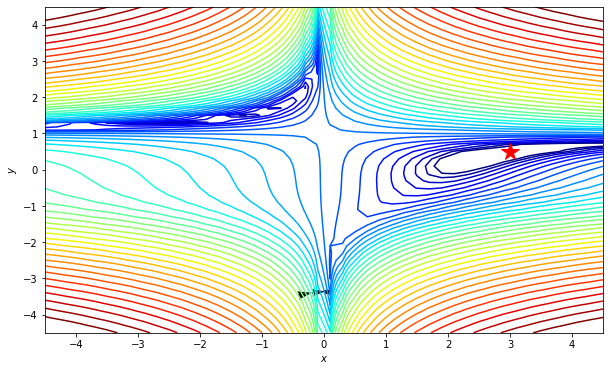

In [133]:
init=np.array([[-0.418], [-3.471]])
fv,grad=func(init)
path2=backtrack(f=func,iterx=init,grad=grad,maxstep=100,t=1,verbose=False)
path=path2
# plot2
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.plot()


foo = np.array([0.049, -3.44])
# f(*foo)

func(np.transpose(foo))

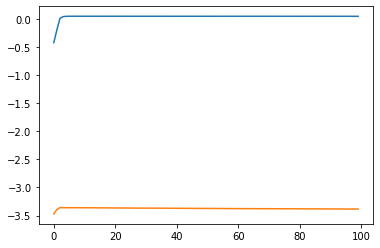

In [135]:
plt.plot(path[0])
plt.plot(path[1])


In [132]:
foo = np.array([-2.619, 1.293])
# f(*foo)

func(np.transpose(foo))

(0.9515716910282389, array([0.1183025 , 0.48757274]))